In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

colors = ["#008800", "#000088"]

In [2]:
data_path = "./data/"
data_files = {
  "Family":              "familyxx.csv",
  "Household":           "househld.csv",
  "Injury Episode":      "injpoiep.csv",
  "Person":              "personsx.csv",
  "Sample Child":        "samchild.csv",
  "Sample Adult":        "samadult.csv",
  "Sample Adult Cancer": "cancerxx.csv"
}

After reading through all of the potential variables provided by the [National Health Interview Survey](https://www.cdc.gov/nchs/nhis/nhis_2015_data_release.htm), I chose to look for a potential link between military status and financial status. More specifically, I wanted to compare whether someone served in the United States military with their current income bracket.

In [3]:
df = pd.read_csv(data_path + data_files["Person"])

The first step after loading in the data was to collect all of the indices that corresponded to anyone who served in the military and use them to filter the population into two groups. Roughly 1 in 15 people who responded to the survey were in the military at some point.

In [4]:
military_indices = (
    (df.ARMFTM1P == 1) | # US military 2001 - ????
    (df.ARMFTM2P == 1) | # US military 1990 - 2001
    (df.ARMFTM3P == 1) | # US military 1975 - 1990
    (df.ARMFTM4P == 1) | # US military 1964 - 1975
    (df.ARMFTM5P == 1) | # US military 1955 - 1964
    (df.ARMFTM6P == 1) | # US military 1950 - 1955
    (df.ARMFTM7P == 1)   # US military ???? - 1950
)
was_military = df[ military_indices]
not_military = df[~military_indices]
len(was_military), len(not_military)

(6863, 96926)

Next, I collected the income data for both groups, split into 11 different brackets:
* 01: \$1-\$4,999
* 02: \$5,000-\$9,999
* 03: \$10,000-\$14,999
* 04: \$15,000-\$19,999
* 05: \$20,000-\$24,999
* 06: \$25,000-\$34,999
* 07: \$35,000-\$44,999
* 08: \$45,000-\$54,999
* 09: \$55,000-\$64,999
* 10: \$65,000-\$74,999
* 11: \$75,000-$\infty$

In [5]:
def get_incomes (df):
    return df[              # people who
        (df.WRKLYR1 == 1) & # worked last year
        (df.ERNYR_P < 12)   # and reported their earnings
    ].ERNYR_P               # were in these income brackets

In [6]:
ym_incomes = get_incomes(was_military)
nm_incomes = get_incomes(not_military)

To get a good idea of what trends may exist in the data, I normalized the values and plotted them, both as a histogram of the actual data and as an estimation of the PDF via KDE.

In [7]:
ym_indices, ym_values = ym_incomes.value_counts().index, ym_incomes.value_counts().values
nm_indices, nm_values = nm_incomes.value_counts().index, nm_incomes.value_counts().values
# ym_values = ym_values / ym_values.max().astype(float)
# nm_values = nm_values / nm_values.max().astype(float)
ym_values = ym_values / ym_values.sum().astype(float)
nm_values = nm_values / nm_values.sum().astype(float)

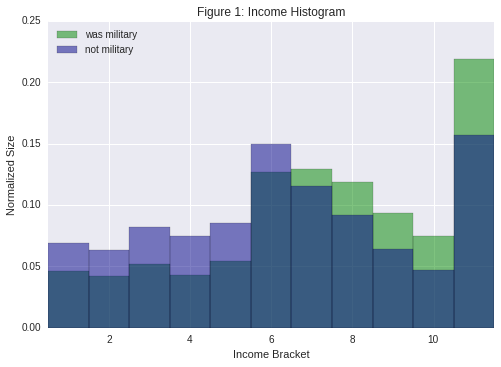

In [8]:
plt.bar(ym_indices - 0.5, ym_values, label = "was military", width = 1, color = colors[0], alpha = 0.5)
plt.bar(nm_indices - 0.5, nm_values, label = "not military", width = 1, color = colors[1], alpha = 0.5)
plt.xlim(0.5, 11.5)
plt.xlabel("Income Bracket")
plt.ylabel("Normalized Size")
plt.title("Figure 1: Income Histogram")
plt.legend(loc = "best")

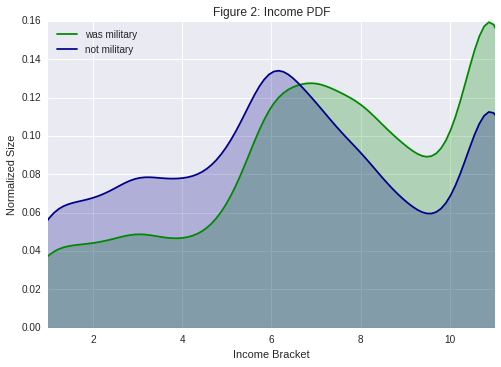

In [9]:
sns.distplot(ym_incomes, label = "was military", color = colors[0],
             hist = False, kde_kws = {"shade": True, "bw": 0.6}, norm_hist = True)
sns.distplot(nm_incomes, label = "not military", color = colors[1],
             hist = False, kde_kws = {"shade": True, "bw": 0.6}, norm_hist = True)
plt.xlim(1, 11)
plt.xlabel("Income Bracket")
plt.ylabel("Normalized Size")
plt.title("Figure 2: Income PDF")
plt.legend(loc = "best")

From our visualizations, we can see that it seems like people who served in the military were underrepresented in low income brackets and overrepresented in high income brackets compared to the rest of the population.

In [10]:
def analyze_brackets (s, n1, n2 = None):
    if n2 is None:
        low, high = s[s <= n1], s[n1 < s]
        total = float(len(s))
        print(len(low), len(high))
        print(len(low) / total, len(high) / total)
    else:
        low, mid, high = s[s <= n1], s[n1 < s][s <= n2], s[n2 < s]
        total = float(len(s))
        print(len(low), len(mid), len(high))
        print(len(low) / total, len(mid) / total, len(high) / total)

In [11]:
analyze_brackets(ym_incomes, 6)
analyze_brackets(nm_incomes, 6)
print("~")
analyze_brackets(ym_incomes, 4, 7)
analyze_brackets(nm_incomes, 4, 7)

(1054, 1839)
(0.3643276875216039, 0.6356723124783962)
(19336, 17501)
(0.5249070228303064, 0.4750929771696935)
~
(529, 900, 1464)
(0.18285516764604218, 0.3110957483581058, 0.506049083995852)
(10676, 12916, 13245)
(0.2898173032548796, 0.3506257295653826, 0.3595569671797378)


| military status | \$ < 35k | 35k <= \$ |
|:-:|---|---|
| was military | 36.43% | 63.57% |
| not military | 52.49% | 47.51% |

| military status | \$ < 20k | 20k <= \$ < 45k | 45k <= \$ |
|:-:|---|---|---|
| was military | 18.29% | 31.11% | 50.60% |
| not military | 28.98% | 35.06% | 35.96% |

The range of our data and the visualized differences between the two groups prompt us to split the income data into even broader bracket groupings for further analysis.

We can observe a significant difference by splitting at the middle of our income data, cutting the groups into lower and upper brackets. About 36% of military respondents make less than \$35k a year, with the other 64% making more than that. For the non-military population, those numbers sit at 52% and 48% respectively.

The discrepancy is even more visible if we segment the data into lower, middle, and upper brackets. Among those who were military, 18% make less than \$20k a year, 31% make between \$20k and \$45k, and 51% make over \$45k. The corresponding numbers for respondents not in the military are 29%, 35%, and 36% respectively.

In [12]:
def effect_size (g1, g2):
    diff = g1.mean() - g2.mean()
    num1, num2 = len(g1), len(g2)
    var1, var2 = g1.var(), g2.var()
    pooled_var = (num1 * var1 + num2 * var2) / (num1 + num2)
    d = diff / np.sqrt(pooled_var)
    return d

In [13]:
effect_size(ym_incomes, nm_incomes)

0.3153318830634142

Further statistical analysis using the Cohen effect size tells us that the difference in means (standardized by dividing by the standard deviation of the data) is about 0.32, which (according to Cohen himself) is somewhere between "small" and "medium" for an effect size.

In [14]:
# TODO: hypothesis and sampling?